In [1]:
!mkdir -p ~/aiffel/chest_xray
!ln -s ~/data/ ~/aiffel/chest_xray

ln: failed to create symbolic link '/aiffel/aiffel/chest_xray/data': File exists


## Setup

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv("HOME"), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Load the data

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
TRAIN_PATH

'/aiffel/aiffel/chest_xray/data/train/*/*'

In [6]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0489-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person348_bacteria_1601.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1066
Pneumonia images count in training set: 3119


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"    # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지: uint8
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지: float32
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    bs = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Visualize the data

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

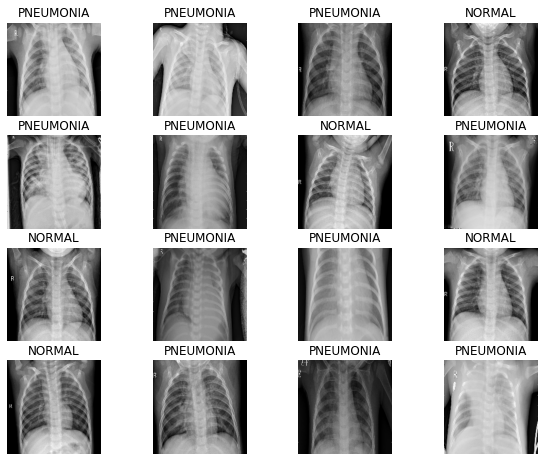

In [18]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
image_batch.shape

TensorShape([16, 180, 180, 3])

In [20]:
image_batch.numpy().shape

(16, 180, 180, 3)

## CNN Modeling
[It's not okay to user Dropout and BN at the same time.](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

[It's okay to use Dropout and BN at the same time.](https://arxiv.org/pdf/1905.05928.pdf)



In [21]:
def conv_block(filters):
    
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

[SeparableConv2d-1](https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers)

[SeparableConv2d-2](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)

depthwise spatial convolution followed by a pointwise convolution which mixes together the resulting output channels. MobileNet, for example, uses this operation to compute the convolutions faster.

In [22]:
def dense_block(units, dropout_rate):
    
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. Data Imbalance

In [24]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL: {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA: {weight_for_1:.2f}")

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [25]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight
    )

Epoch 1/25
261/261 [==============================] - 72s 205ms/step - loss: 0.5252 - accuracy: 0.7288 - precision: 0.9271 - recall: 0.6981 - val_loss: 0.5973 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2957 - accuracy: 0.8782 - precision: 0.9667 - recall: 0.8699 - val_loss: 1.0462 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2178 - accuracy: 0.9087 - precision: 0.9826 - recall: 0.8957 - val_loss: 0.2349 - val_accuracy: 0.8952 - val_precision: 0.8754 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1952 - accuracy: 0.9202 - precision: 0.9848 - recall: 0.9094 - val_loss: 0.1788 - val_accuracy: 0.9288 - val_precision: 0.9971 - val_recall: 0.9050
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1613 - accura

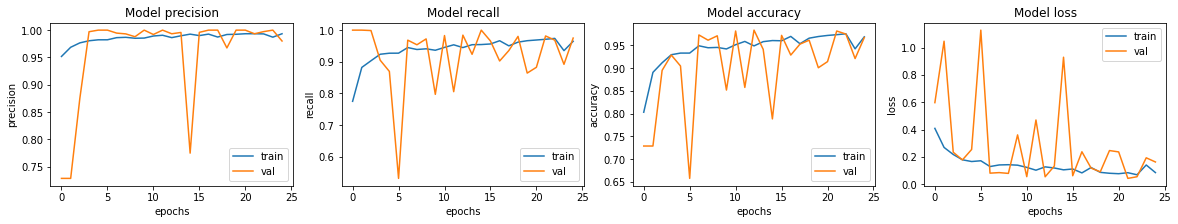

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
axs = axes.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    axs[i].plot(history.history[met])
    axs[i].plot(history.history['val_' + met])
    
    axs[i].set_title(f"Model {met}")
    axs[i].set_xlabel('epochs')
    axs[i].set_ylabel(met)
    axs[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}")

39/39 [==============================] - 3s 76ms/step - loss: 1.3816 - accuracy: 0.7837 - precision: 0.7466 - recall: 0.9897
Loss: 1.3816378116607666,
Accuracy: 0.7836538553237915,
Precision: 0.7466151118278503,
Recall: 0.9897435903549194


## Data Augmentation

의료영상은 사용할 수 있는 데이터가 적기 때문에 따라서 다양한 방법의 Data augmentation 기법을 사용합니다. 하지만 일반적으로 사용하는 augmentation 기법을 사용할 수는 없습니다.

고양이 사진을 분류하는 문제를 해결할 때를 생각해봅시다. 이 때는 데이터가 부족하다면 사진을 좌우로 뒤집고, 위 아래로 뒤집고 어느정도 회전을 시키기도 합니다. 추가적으로 밝기를 조절하기도 하고 노이즈를 추가하기도 합니다. 이러한 방법 중 어떤 방법은 의료영상에 사용해도 되고 어떤 방법은 사용하면 오히려 방해가 될 수 있을 지 잘 생각해보면 사용하는 것이 중요합니다.

### (1) Horizontal flip

폐렴 검진을 위해 살펴본 흉부 X-RAY 사진에서 좌우를 뒤집어 데이터를 증강시키는 건 오히려 방해가 될까요?

> For example, in X-ray data the heart is typically on the right of the image, however the image below shows a horizontal flip augmentation inadvertently creates a medical condition call situs inversus. 

*Source: [Data Augmentation in Medical Images](https://towardsdatascience.com/data-augmentation-in-medical-images-95c774e6eaae)*

사진의 좌우를 뒤집게 되면 장기가 정반대에 위치하게 되고 이를 'situs inversus' 라고 부릅니다. 장기의 '위치'에 대한 정보가 중요한 경우 문제가 될 수 있습니다.

하지만 폐렴은 X-RAY 사진상 드러나는 다양한 양상의 음영(폐 부위에 희미한 그림자)증가를 통해 확인한다고 합니다. 따라서 현재의 생각으로는 위치 정보가 그렇게 중요하지는 않을 것 같습니다. 따라서 좌우를 바꾸는 Horizontal flip으로 데이터양을 늘리고 학습을 진행해보겠습니다.


In [29]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [31]:
image_batch, label_batch = next(iter(train_ds))

In [32]:
image_batch.numpy().shape

(16, 180, 180, 3)

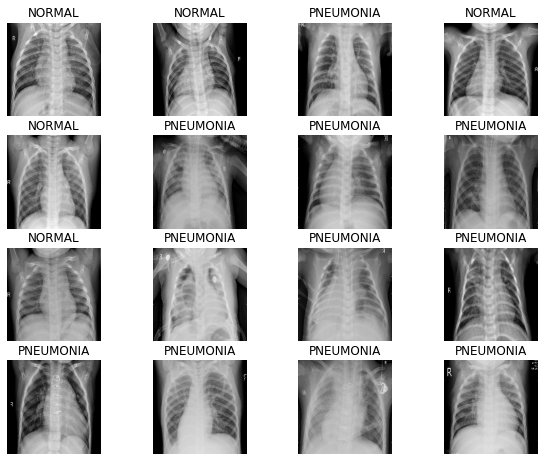

In [33]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [34]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL: {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA: {weight_for_1:.2f}")

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [35]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight
    )

Epoch 1/25
261/261 [==============================] - 43s 138ms/step - loss: 0.5032 - accuracy: 0.7248 - precision: 0.9214 - recall: 0.6929 - val_loss: 0.6843 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2703 - accuracy: 0.8914 - precision: 0.9679 - recall: 0.8858 - val_loss: 1.3591 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 135ms/step - loss: 0.1998 - accuracy: 0.9214 - precision: 0.9795 - recall: 0.9152 - val_loss: 0.1401 - val_accuracy: 0.9529 - val_precision: 0.9903 - val_recall: 0.9447
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.1879 - accuracy: 0.9257 - precision: 0.9859 - recall: 0.9150 - val_loss: 0.1330 - val_accuracy: 0.9471 - val_precision: 0.9377 - val_recall: 0.9934
Epoch 5/25
261/261 [==============================] - 35s 136ms/step - loss: 0.1706 - accura

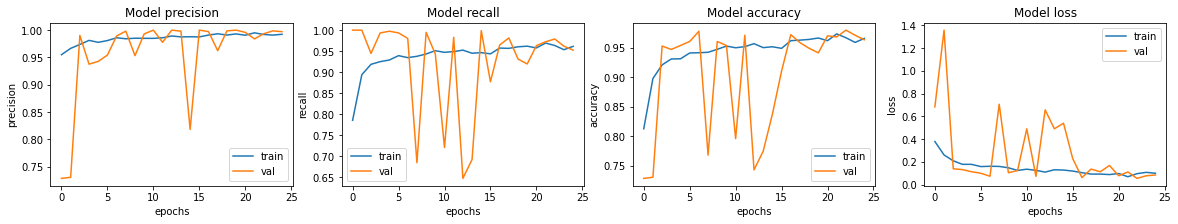

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
axs = axes.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    axs[i].plot(history.history[met])
    axs[i].plot(history.history['val_' + met])
    
    axs[i].set_title(f"Model {met}")
    axs[i].set_xlabel('epochs')
    axs[i].set_ylabel(met)
    axs[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}")

39/39 [==============================] - 3s 74ms/step - loss: 0.8527 - accuracy: 0.8221 - precision: 0.7888 - recall: 0.9769
Loss: 0.8526580929756165,
Accuracy: 0.8221153616905212,
Precision: 0.7888198494911194,
Recall: 0.9769230484962463


- [ ] confusion matrix

Horizontal Flip 후 Accuracy가 82%로 상승한 모습을 보입니다. 다른 지표들도 전과 비슷하거나 조금씩 상승했습니다.

### (2) Horizontal and vertical flip

데이터의 수는 늘어나면서 학습 자체에 방해가 되지않아 성능이 개선됐습니다. 그렇다면 수직으로 바꾸는 건 어떨까요? 어차피 폐 주변의 그림자만 체크하면 되니까 상관이 없지 않을까요?

Horizontal, vertical flip을 모두 시행한 데이터를 통해 실험을 해보겠습니다.


In [39]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [40]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_flip_up_down(image) # 랜덤하게 상하를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [41]:
image_batch, label_batch = next(iter(train_ds))

In [42]:
image_batch.numpy().shape

(16, 180, 180, 3)

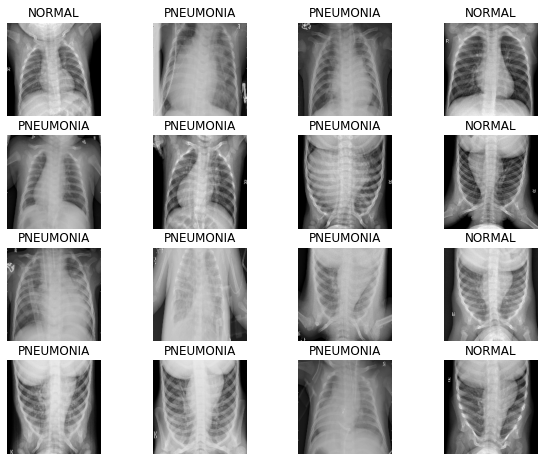

In [43]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [44]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL: {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA: {weight_for_1:.2f}")

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [45]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [46]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight
    )

Epoch 1/25
261/261 [==============================] - 43s 137ms/step - loss: 0.5875 - accuracy: 0.6809 - precision: 0.8967 - recall: 0.6552 - val_loss: 0.6107 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 134ms/step - loss: 0.3164 - accuracy: 0.8667 - precision: 0.9682 - recall: 0.8551 - val_loss: 1.1299 - val_accuracy: 0.7298 - val_precision: 0.7298 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2454 - accuracy: 0.8986 - precision: 0.9742 - recall: 0.8904 - val_loss: 0.1254 - val_accuracy: 0.9481 - val_precision: 0.9537 - val_recall: 0.9763
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2139 - accuracy: 0.9146 - precision: 0.9824 - recall: 0.9045 - val_loss: 0.6341 - val_accuracy: 0.7683 - val_precision: 0.9981 - val_recall: 0.6834
Epoch 5/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2256 - accura

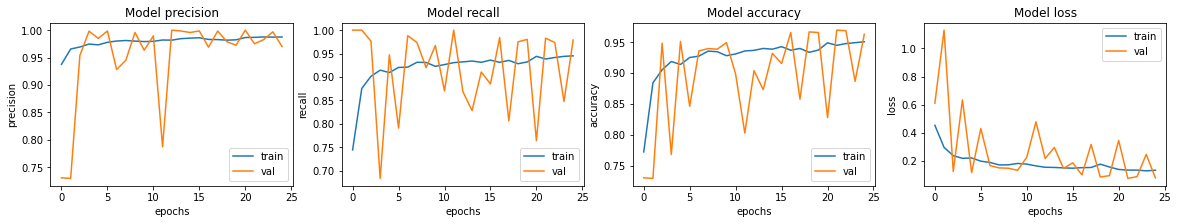

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
axs = axes.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    axs[i].plot(history.history[met])
    axs[i].plot(history.history['val_' + met])
    
    axs[i].set_title(f"Model {met}")
    axs[i].set_xlabel('epochs')
    axs[i].set_ylabel(met)
    axs[i].legend(['train', 'val'])

In [48]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}")

39/39 [==============================] - 3s 75ms/step - loss: 0.9674 - accuracy: 0.7500 - precision: 0.7159 - recall: 0.9949
Loss: 0.9674490690231323,
Accuracy: 0.75,
Precision: 0.7158671617507935,
Recall: 0.9948717951774597


오히려 accuracy 및 성능이 많이 떨어진 모습을 보입니다. 그렇다면 Vertical flip은 하지 말아야겠다는 결론을 일단은 내려보겠습니다.

### (3) Other augmentations

더욱 다양한 방법의 augmentation을 생각해보겠습니다. 밝기와 대비가 어느정도 변해도 큰 영향이 있을 것 같지는 않습니다. 대비나 밝기를 오히려 적절히 조절하면 뿌옇게 변한 부분이 더 드러나 판단이 쉬워질 수도 있을 것 같습니다. 따라서 마지막으로 horizontal flip, brightness, contrast를 모두 조정해 augmentation을 하며 학습을 진행해보겠습니다.


In [78]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [79]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_brightness(image, max_delta=0.2) # 랜덤하게 밝기를 조절합니다.
    image = tf.image.random_contrast(image, lower=0.2, upper=0.6) # 랜덤하게 대비를 조절합니다.
    return image, label


def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

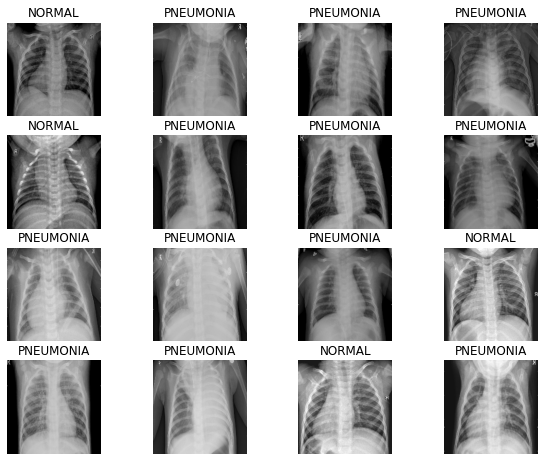

In [80]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [81]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL: {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA: {weight_for_1:.2f}")

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [82]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [83]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight
    )

Epoch 1/25
261/261 [==============================] - 43s 137ms/step - loss: 0.8756 - accuracy: 0.5352 - precision: 0.7829 - recall: 0.5311 - val_loss: 0.7972 - val_accuracy: 0.2712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 35s 135ms/step - loss: 0.7644 - accuracy: 0.5128 - precision: 0.7684 - recall: 0.5111 - val_loss: 0.7760 - val_accuracy: 0.2721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 35s 135ms/step - loss: 0.7551 - accuracy: 0.4882 - precision: 0.7515 - recall: 0.4878 - val_loss: 0.7386 - val_accuracy: 0.3740 - val_precision: 0.8125 - val_recall: 0.1879
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.6828 - accuracy: 0.5393 - precision: 0.8002 - recall: 0.5200 - val_loss: 0.4665 - val_accuracy: 0.8327 - val_precision: 0.8431 - val_recall: 0.9474
Epoch 5/25
261/261 [==============================] - 35s 136ms/step - loss:

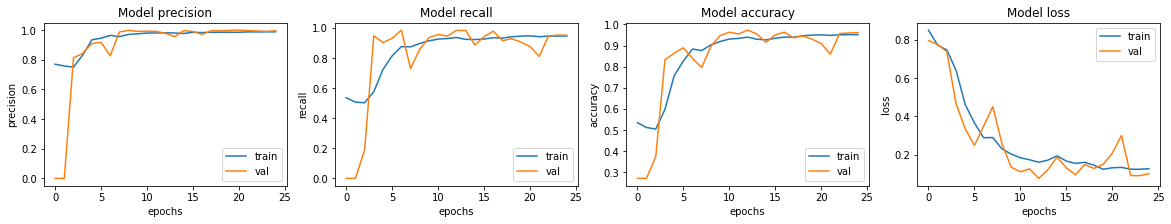

In [84]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
axs = axes.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    axs[i].plot(history.history[met])
    axs[i].plot(history.history['val_' + met])
    
    axs[i].set_title(f"Model {met}")
    axs[i].set_xlabel('epochs')
    axs[i].set_ylabel(met)
    axs[i].legend(['train', 'val'])

In [85]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}")

39/39 [==============================] - 3s 75ms/step - loss: 0.8466 - accuracy: 0.8109 - precision: 0.7776 - recall: 0.9769
Loss: 0.8466266989707947,
Accuracy: 0.8108974099159241,
Precision: 0.777550995349884,
Recall: 0.9769230484962463


밝기와 대비 변화까지 주니 오히려 Accuracy는 낮아졌습니다.

## 소감

이번 노드를 진행하면서 다양한 augmentation을 어떻게 사용하는 것이 좋을 지, 또 사용하는 것이 좋을 지에 대해 다양한 방안으로 생각할 수 있어서 좋았습니다. 지난 노드에서 전처리를 하면서 각 문제마다 다양한 방법이 존재하는 것 처럼 augmentation에도 다양한 방법이 있고 이를 어떻게 적응하냐에 따라 다양한 결과가 나올 수 있다는 것을 알게 되었습니다.

이번엔 괜히 시간이 없어서 많은 시도를 못해봐서 아쉽습니다.

**추가적으로 꼭 해볼 것**
- [ ] Earlystopping으로 더 좋은 곳에서 학습 멈추기
- [ ] 다른 CNN 사용해보기, pretrained-network
- [ ] 다른 augmentation 사용해보기
